# Rosenbrock banana

Here, we perform optimization for the Rosenbrock banana function, which does not require an AMICI model. In particular, we try several ways of specifying derivative information.

In [1]:
import pypesto
import pypesto.visualize as visualize
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## Define the objective and problem

In [2]:
def res_rosen(x):
    """ The Rosenbrock function.

    Computes the residuals of the Rosenbrock function.

    Parameters
    ----------
    x : array_like
        1-D array of points at which the Rosenbrock function is to be computed.

    Returns
    -------
    f : array_like
        The residuals of the Rosenbrock function.
    """
    res = np.array([10.0 * (x[1:] - x[:-1]**2), (1.0 - x[:-1])]).flatten()
    return res


def sres_rosen(x):
    """

    The sensitivities (i.e. residual derivatives) of the Rosenbrock function.

    Parameters
    ----------
    x : array_like
        1-D array of points at which the Rosenbrock function is to be computed.

    Returns
    -------
    f : array_like
        The residual sensitivities of the Rosenbrock function.
    """
    n = len(x) - 1
    dof = n * 2
    der = np.zeros((dof, len(x)))
    for i in range(n):
        der[i, i:i+2] = np.array([-20 * x[i], 10.0])
        der[n + i, i] = -1.0
    return der

def res2_rosen(x):
    return (res_rosen(x),
            sres_rosen(x))

# first type of objective
objective1 = pypesto.Objective(fun=sp.optimize.rosen, 
                               grad=sp.optimize.rosen_der, 
                               hess=sp.optimize.rosen_hess,
                               res=res_rosen,
                               sres=sres_rosen)

# second type of objective
def rosen2(x):
    return (sp.optimize.rosen(x),
            sp.optimize.rosen_der(x),
            sp.optimize.rosen_hess(x))
objective2 = pypesto.Objective(fun=rosen2, grad=True, hess=True, res=res2_rosen, sres=True)

dim_full = 10
lb = -5 * np.ones((dim_full, 1))
ub = 5 * np.ones((dim_full, 1))

problem1 = pypesto.Problem(objective=objective1, lb=lb, ub=ub)
problem2 = pypesto.Problem(objective=objective2, lb=lb, ub=ub)

### Illustration

In [3]:
x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
x, y = np.meshgrid(x, y)
z = np.zeros_like(x)
for j in range(0, x.shape[0]):
    for k in range(0, x.shape[1]):
        z[j,k] = objective1([x[j,k], y[j,k]], (0,))     

Text(0.5, 0.92, 'cost function values')

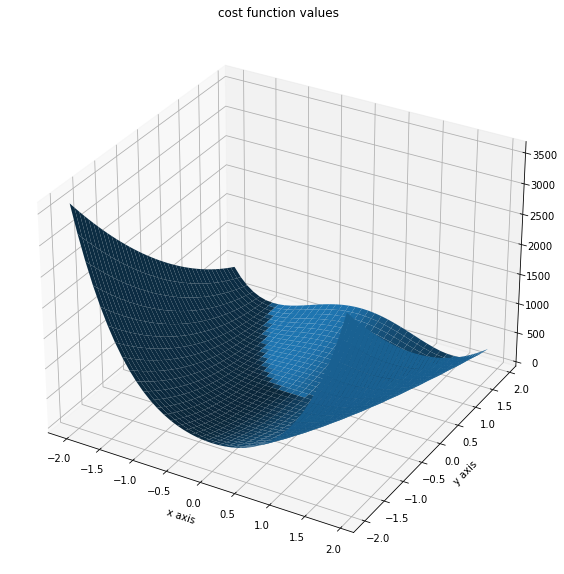

In [4]:
fig = plt.figure()
fig.set_size_inches(*(14,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X=x, Y=y, Z=z)
plt.xlabel('x axis')
plt.ylabel('y axis')
ax.set_title('cost function values')

## Run optimization

In [5]:
import pypesto.optimize as optimize

In [6]:
%%time

# create different optimizers
optimizer_bfgs = optimize.ScipyOptimizer(method='l-bfgs-b')
optimizer_tnc = optimize.ScipyOptimizer(method='TNC')
optimizer_dogleg = optimize.ScipyOptimizer(method='dogleg')
optimizer_trf = optimize.ScipyOptimizer(method='ls_trf')

# set number of starts
n_starts = 20

# save optimizer trace
history_options = pypesto.HistoryOptions(trace_record=True)

# Run optimizaitons for different optimzers
result1_bfgs = optimize.minimize(
    problem=problem1, optimizer=optimizer_bfgs,
    n_starts=n_starts, history_options=history_options)
result1_tnc = optimize.minimize(
    problem=problem1, optimizer=optimizer_tnc,
    n_starts=n_starts, history_options=history_options)
result1_dogleg = optimize.minimize(
    problem=problem1, optimizer=optimizer_dogleg,
    n_starts=n_starts, history_options=history_options)

CPU times: user 1.17 s, sys: 17.8 ms, total: 1.19 s
Wall time: 1.21 s


/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method dogleg cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/usr/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:634: OptimizeWarning: Unknown solver options: ftol
  return _minimize_dogleg(fun, x0, args, jac, hess,


In [7]:
result1_trf = optimize.minimize(
    problem=problem1, optimizer=optimizer_trf,
    n_starts=n_starts, history_options=history_options)

In [8]:
# Optimize second type of objective
result2_tnc = optimize.minimize(
    problem=problem2, optimizer=optimizer_tnc, n_starts=n_starts)
result2_trf = optimize.minimize(
    problem=problem2, optimizer=optimizer_trf, n_starts=n_starts)

### Visualize and compare optimization results

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Offsetted function value (relative to best start)'>

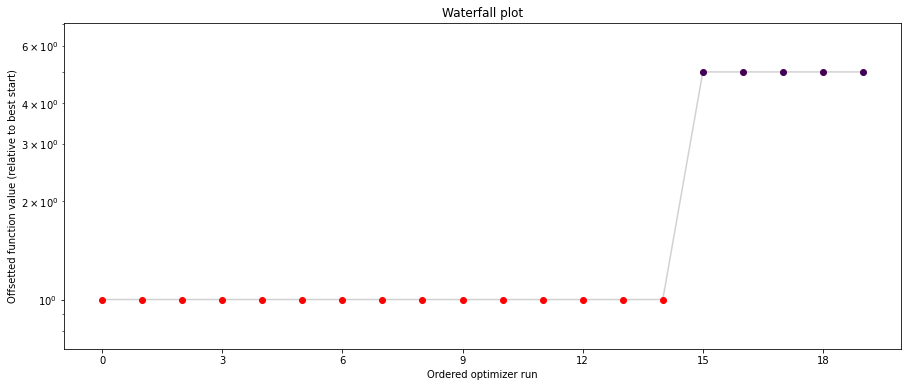

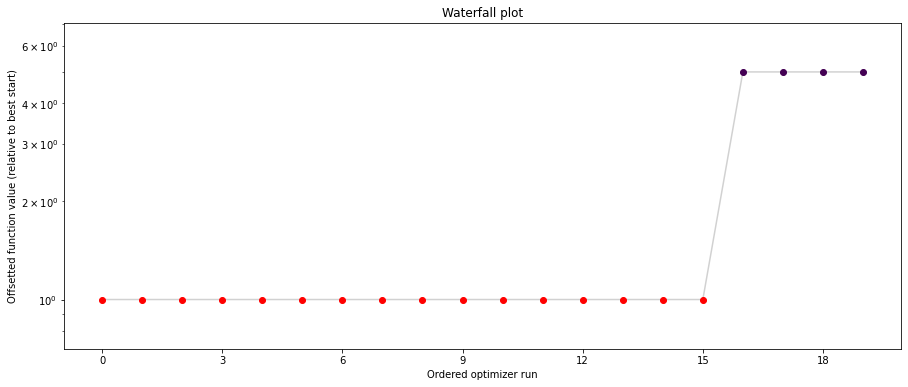

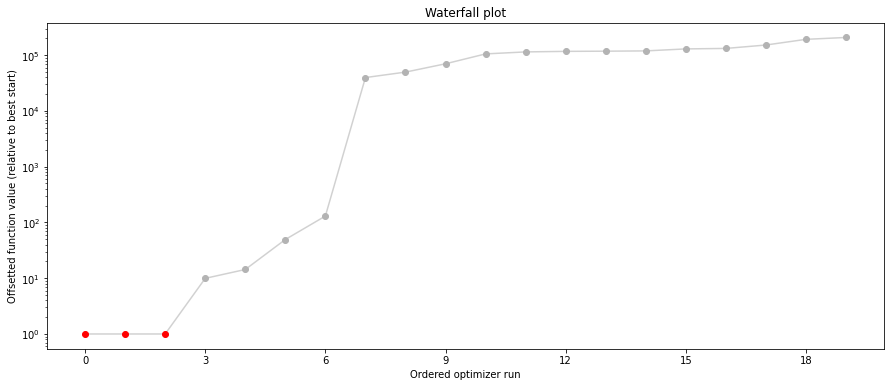

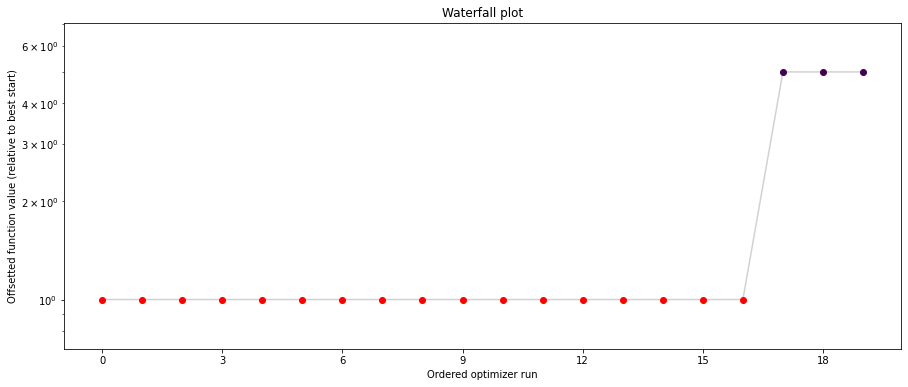

In [9]:
# plot separated waterfalls
visualize.waterfall(result1_bfgs, size=(15,6))
visualize.waterfall(result1_tnc, size=(15,6))
visualize.waterfall(result1_dogleg, size=(15,6))
visualize.waterfall(result1_trf, size=(15,6))

We can now have a closer look, which method perfomred better: Let's first compare bfgs and TNC, since both methods gave good results. How does the fine convergence look like?

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Function value'>

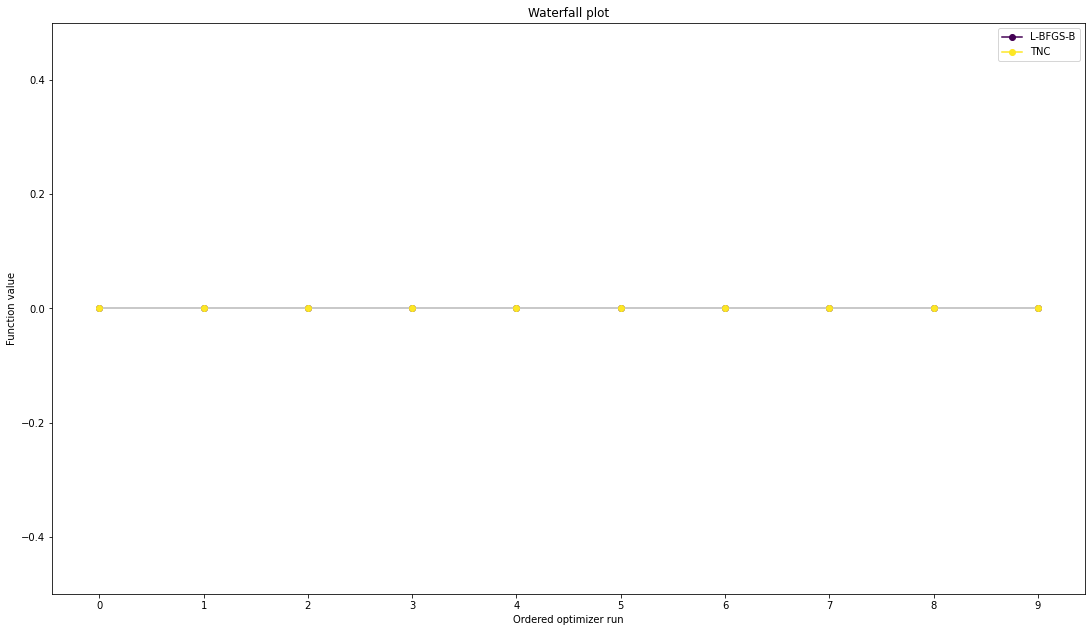

In [10]:
# plot one list of waterfalls
visualize.waterfall([result1_bfgs, result1_tnc],
                    legends=['L-BFGS-B', 'TNC'],
                    start_indices=10,
                    scale_y='lin')

Second optimum at: 3.986579112930132


/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Function value'>

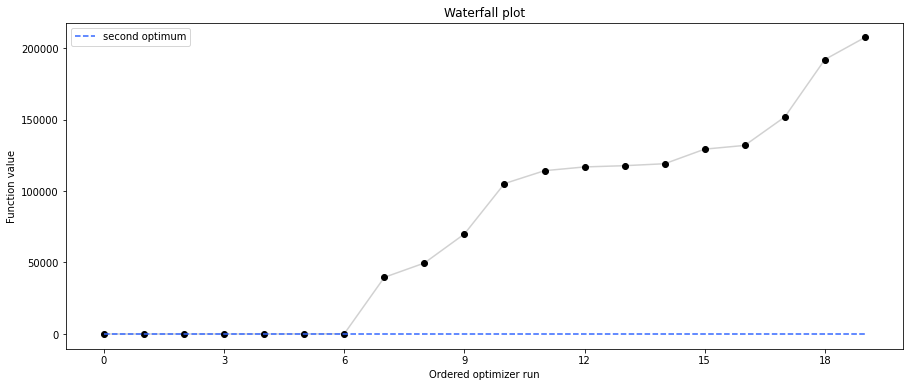

In [11]:
# retrieve second optimum
all_x = result1_bfgs.optimize_result.get_for_key('x')
all_fval = result1_bfgs.optimize_result.get_for_key('fval')
x = all_x[19]
fval = all_fval[19]
print('Second optimum at: ' + str(fval))

# create a reference point from it
ref = {'x': x, 'fval': fval, 'color': [
    0.2, 0.4, 1., 1.], 'legend': 'second optimum'}
ref = visualize.create_references(ref)

# new waterfall plot with reference point for second optimum
visualize.waterfall(result1_dogleg, size=(15,6), 
                    scale_y='lin', y_limits=[-1, 101],
                    reference=ref, colors=[0., 0., 0., 1.])

## Visualize parameters

There seems to be a second local optimum. We want to see whether it was also found by the dogleg method

<AxesSubplot:title={'center':'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

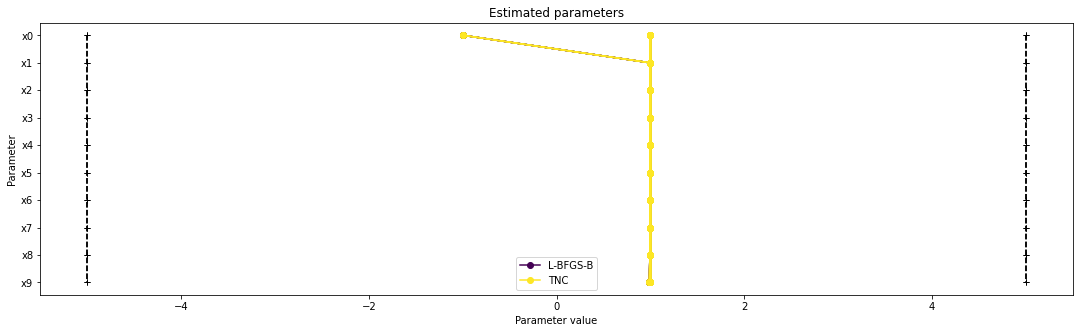

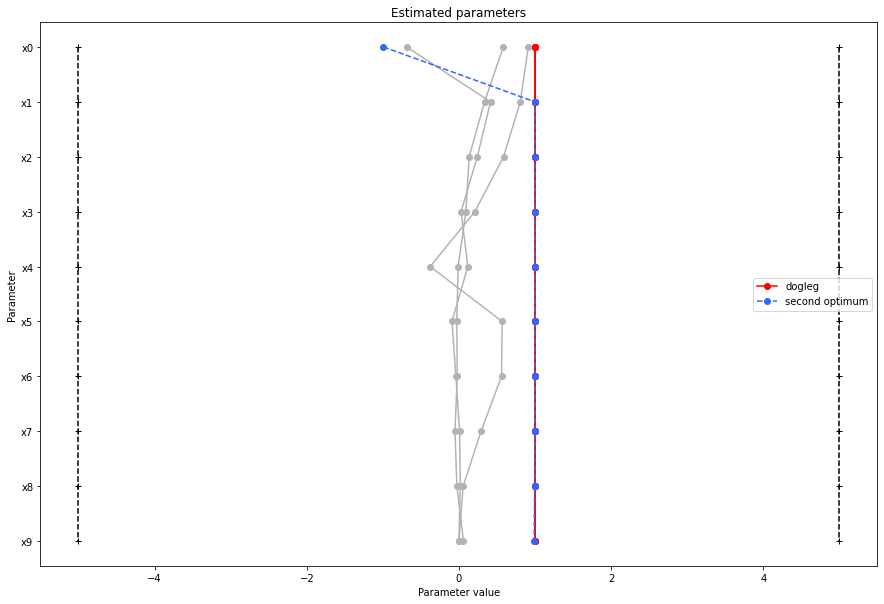

In [12]:
visualize.parameters([result1_bfgs, result1_tnc],
                     legends=['L-BFGS-B', 'TNC'],
                     balance_alpha=False)
visualize.parameters(result1_dogleg,
                     legends='dogleg',
                     reference=ref,
                     size=(15,10),
                     start_indices=[0, 1, 2, 3, 4, 5],
                     balance_alpha=False)

If the result needs to be examined in more detail, it can easily be exported as a pandas.DataFrame:

In [13]:
df = result1_tnc.optimize_result.as_dataframe(
    ['fval', 'n_fval', 'n_grad', 'n_hess', 'n_res', 'n_sres', 'time'])
df.head()

,fval,n_fval,n_grad,n_hess,n_res,n_sres,time
0,3.206731e-12,192,192,0,0,0,0.030346
1,7.017146e-12,205,205,0,0,0,0.035278
2,7.499727e-12,148,148,0,0,0,0.026033
3,5.764282e-11,143,143,0,0,0,0.026323
4,6.358377e-11,246,246,0,0,0,0.041593


### Optimizer history

Let's compare optimzer progress over time.

<AxesSubplot:title={'center':'Optimizer history'}, xlabel='Optimizer steps', ylabel='objective value'>

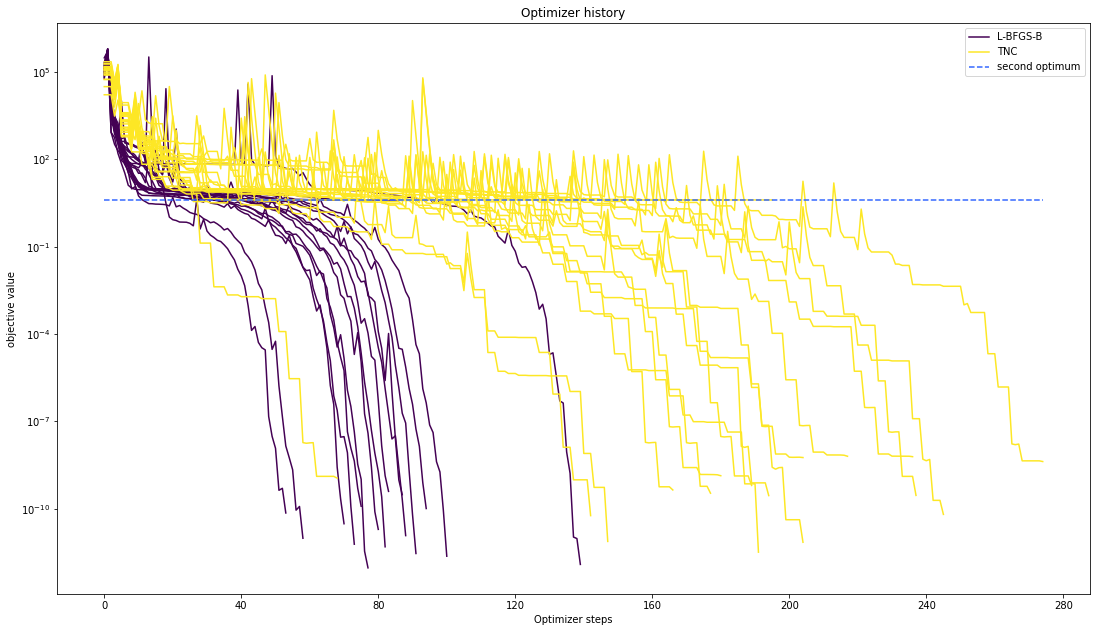

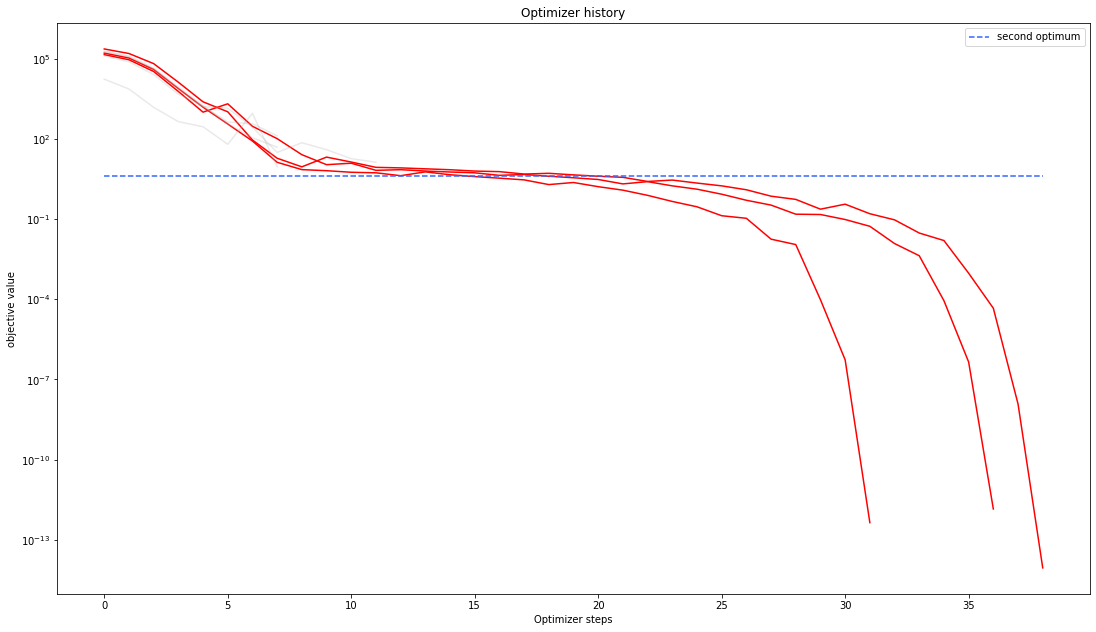

In [14]:
# plot one list of waterfalls
visualize.optimizer_history([result1_bfgs, result1_tnc],
                            legends=['L-BFGS-B', 'TNC'],
                            reference=ref)
# plot one list of waterfalls
visualize.optimizer_history(result1_dogleg,
                            reference=ref)

We can also visualize this usign other scalings or offsets...

<AxesSubplot:title={'center':'Optimizer history'}, xlabel='Optimizer steps', ylabel='objective value'>

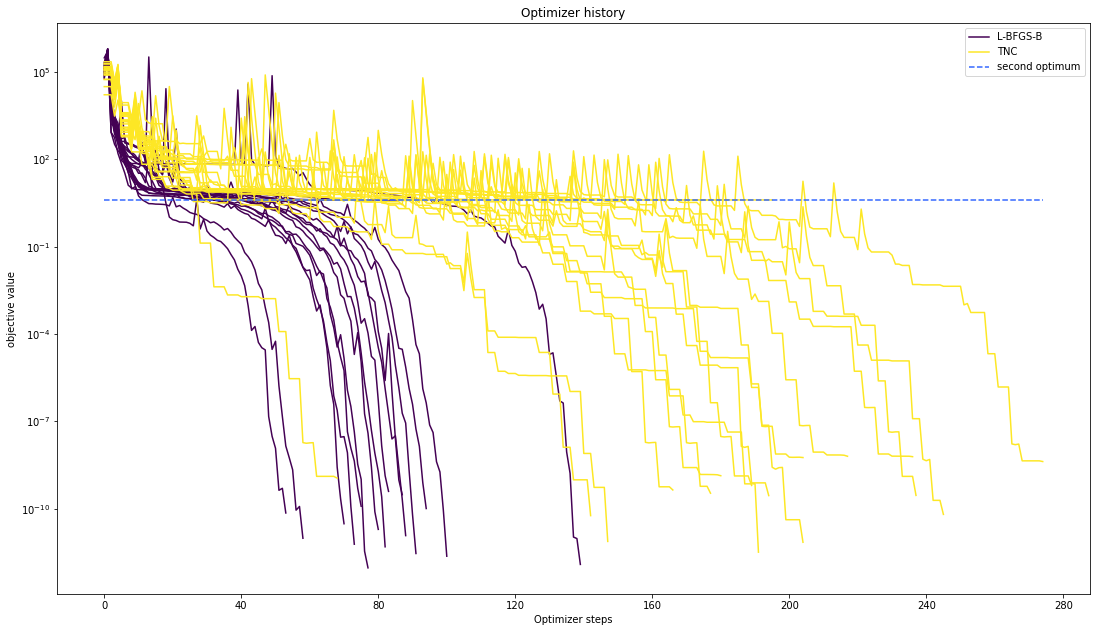

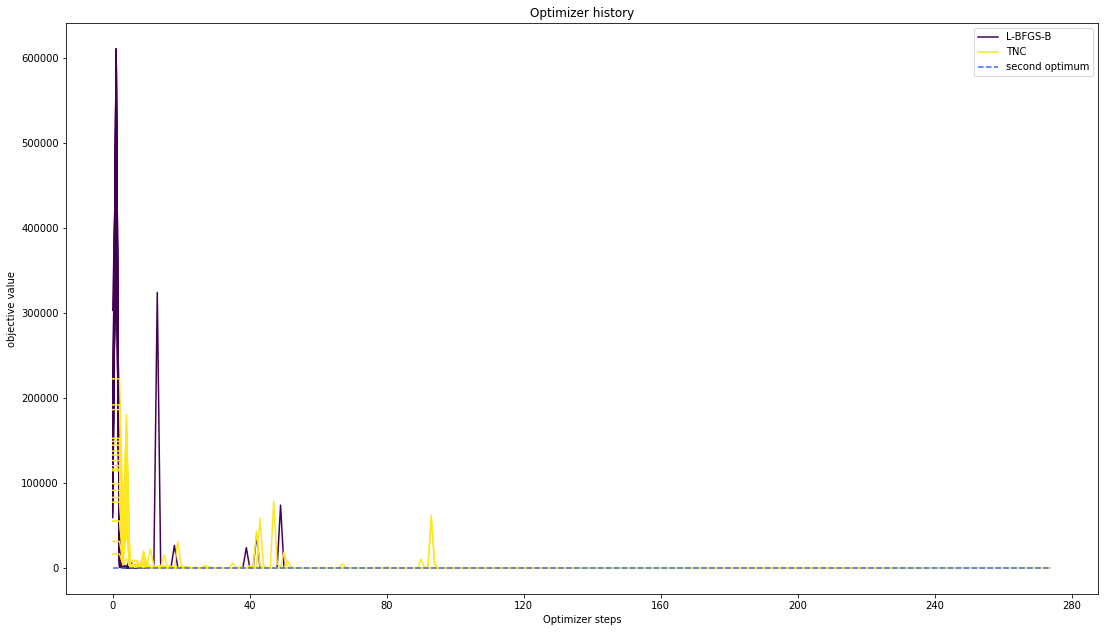

In [15]:
# plot one list of waterfalls
visualize.optimizer_history([result1_bfgs, result1_tnc],
                            legends=['L-BFGS-B', 'TNC'],
                            reference=ref,
                            offset_y=0.)

# plot one list of waterfalls
visualize.optimizer_history([result1_bfgs, result1_tnc],
                            legends=['L-BFGS-B', 'TNC'],
                            reference=ref,
                            scale_y='lin',
                            y_limits=[-1., 11.])

## Compute profiles

The profiling routine needs a problem, a results object and an optimizer.

Moreover it accepts an index of integer (profile_index), whether or not a profile should be computed.

Finally, an integer (result_index) can be passed, in order to specify the local optimum, from which profiling should be started.

In [16]:
import pypesto.profile as profile

In [17]:
%%time

# compute profiles
profile_options = profile.ProfileOptions(min_step_size=0.0005,
    delta_ratio_max=0.05,
    default_step_size=0.005,
    ratio_min=0.01)

result1_bfgs = profile.parameter_profile(
    problem=problem1,
    result=result1_bfgs,
    optimizer=optimizer_bfgs,
    profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=0,
    profile_options=profile_options)

# compute profiles from second optimum
result1_bfgs = profile.parameter_profile(
    problem=problem1,
    result=result1_bfgs,
    optimizer=optimizer_bfgs,
    profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=19,
    profile_options=profile_options)

CPU times: user 377 ms, sys: 11.6 ms, total: 389 ms
Wall time: 385 ms


### Visualize and analyze results

pypesto offers easy-to-use visualization routines:

/Users/kristianmeyer/Desktop/pythonProject/pyPESTO/pypesto/visualize/profiles.py:454: UserWarning: Requested to plot profile for parameter index 2, but profile has not been computed.
  warn('Requested to plot profile for parameter index %i, '
/Users/kristianmeyer/Desktop/pythonProject/pyPESTO/pypesto/visualize/profiles.py:454: UserWarning: Requested to plot profile for parameter index 7, but profile has not been computed.
  warn('Requested to plot profile for parameter index %i, '
/Users/kristianmeyer/Desktop/pythonProject/pyPESTO/pypesto/visualize/profiles.py:208: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax.append(fig.add_subplot(rows, columns, counter + 1))
/Users/kristianmeyer/Desktop/pythonProject/pyPESTO/pypesto/visualize/profiles.py:208: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will 

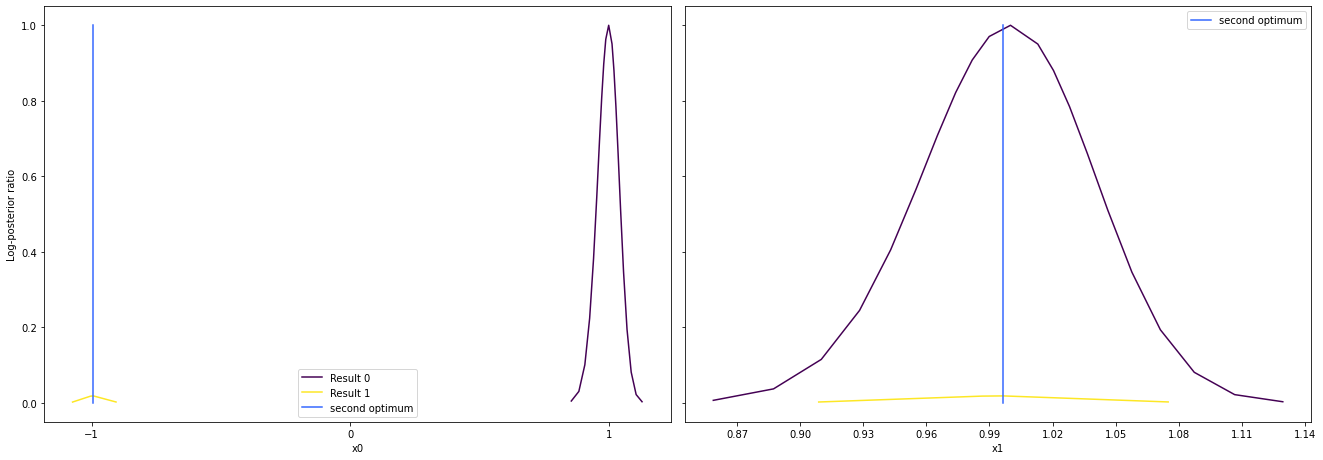

In [18]:
# specify the parameters, for which profiles should be computed
ax = visualize.profiles(result1_bfgs, profile_indices = [0,1,2,5,7], 
                        reference=ref, profile_list_ids=[0, 1])

### Approximate profiles

When computing the profiles is computationally too demanding, it is possible to employ to at least consider a normal approximation with covariance matrix given by the Hessian or FIM at the optimal parameters.

In [19]:
%%time

result1_tnc = profile.approximate_parameter_profile(
    problem=problem1,
    result=result1_bfgs,
    profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=0,
    n_steps=1000)

CPU times: user 78 ms, sys: 36.1 ms, total: 114 ms
Wall time: 20.8 ms


/Users/kristianmeyer/Desktop/pythonProject/pyPESTO/pypesto/profile/approximate.py:97: RuntimeWarning: divide by zero encountered in log
  fvals = - np.log(ys)


These approximate profiles require at most one additional function evaluation, can however yield substantial approximation errors:

/Users/kristianmeyer/Desktop/pythonProject/pyPESTO/pypesto/visualize/profiles.py:454: UserWarning: Requested to plot profile for parameter index 2, but profile has not been computed.
  warn('Requested to plot profile for parameter index %i, '
/Users/kristianmeyer/Desktop/pythonProject/pyPESTO/pypesto/visualize/profiles.py:454: UserWarning: Requested to plot profile for parameter index 7, but profile has not been computed.
  warn('Requested to plot profile for parameter index %i, '
/Users/kristianmeyer/Desktop/pythonProject/pyPESTO/pypesto/visualize/profiles.py:208: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax.append(fig.add_subplot(rows, columns, counter + 1))
/Users/kristianmeyer/Desktop/pythonProject/pyPESTO/pypesto/visualize/profiles.py:208: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will 

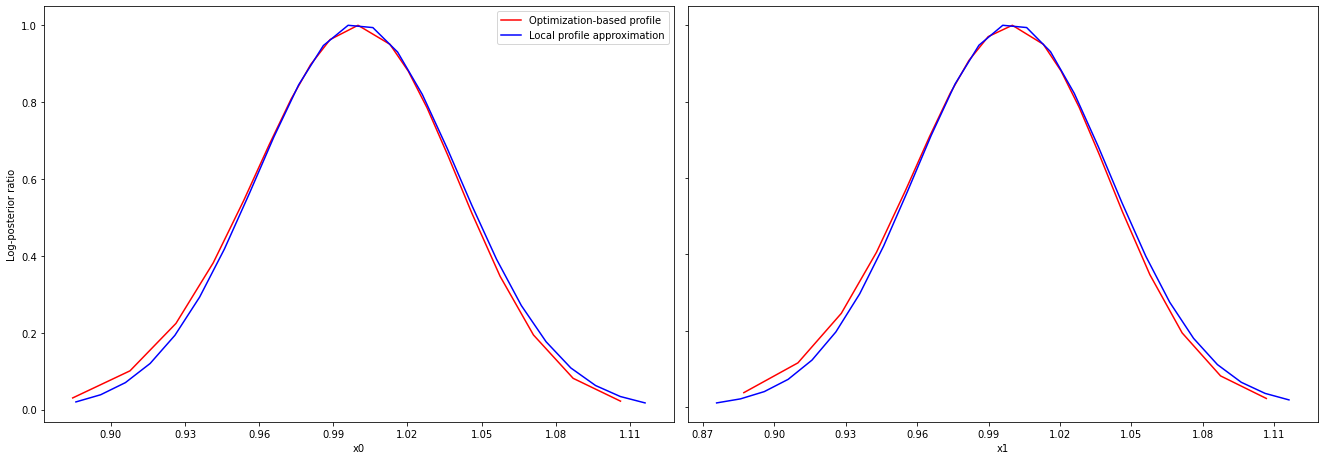

In [20]:
axes = visualize.profiles(
    result1_bfgs, profile_indices = [0,1,2,5,7], profile_list_ids=[0, 2], 
    ratio_min=0.01, colors=[(1,0,0,1), (0,0,1,1)], 
    legends=["Optimization-based profile", "Local profile approximation"])

We can also plot approximate confidence intervals based on profiles:

<AxesSubplot:xlabel='Parameter value', ylabel='Parameter'>

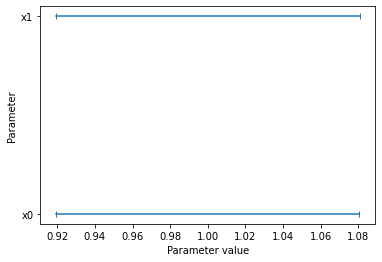

In [21]:
visualize.profile_cis(
    result1_bfgs, confidence_level=0.95, profile_list=2)